# RGA Data Analysis

Analysis of SRS RGA data files from gas collision experiments.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

from scipy.optimize import curve_fit

import rga_utils as rga

plt.style.use('clarke-default')

## Load and plot Analog scan (mass spectrum)

In [3]:
# Find all Analog files
analog_dir = Path('RGAData/Analog/')
analog_files = sorted(analog_dir.glob('*.rgadata'))
print(f"Found {len(analog_files)} Analog files")
for f in analog_files:
    print(f"  {f.name}")

Found 6 Analog files
  Analog-20260119-160557-859.rgadata
  Analog-20260119-165423-970.rgadata
  Analog-20260119-170006-421.rgadata
  Analog-20260119-170320-574.rgadata
  Analog-20260119-170514-350.rgadata
  Analog-20260119-172303-338.rgadata


In [4]:
# Load the first Analog file
analog_result = rga.parse_rgadata_file(analog_files[0])

print(f"Mode: {analog_result['mode_name']}")
print(f"Mass range: {analog_result['start_mass']} - {analog_result['stop_mass']} AMU")
print(f"Points per AMU: {analog_result['points_per_amu']}")
print(f"Number of scans: {analog_result['data'].shape[0]}")
print(f"Scan start time: {rga.get_scan_time(analog_result)}")

Mode: Analog
Mass range: 1 - 140 AMU
Points per AMU: 10
Number of scans: 96
Scan start time: 2026-01-19 16:05:57-05:00


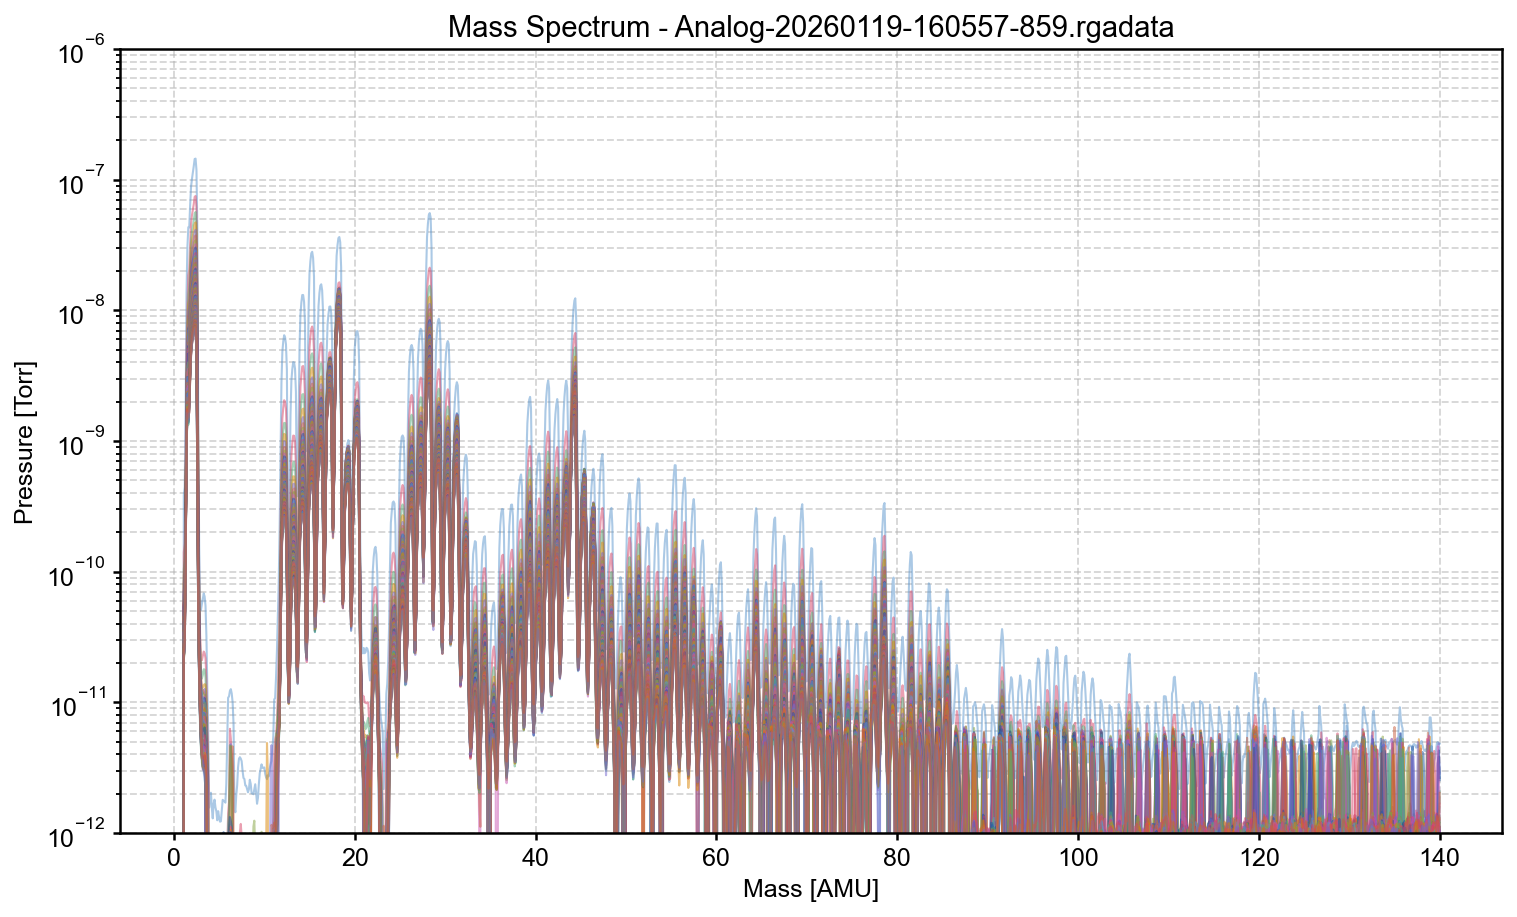

In [5]:
# Plot all scans from the Analog file
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

masses = analog_result['masses']
data = analog_result['data']
timestamps = analog_result['timestamps']

for i in range(data.shape[0]):
    ax.semilogy(masses, data[i, :], alpha=0.5, label=f't = {timestamps[i]/1000:.1f} s')

ax.set_xlabel('Mass [AMU]')
ax.set_ylabel('Pressure [Torr]')
ax.set_ylim([1e-12, 1e-6])
ax.set_title(f'Mass Spectrum - {analog_files[0].name}')
ax.grid(which='both')
# ax.legend(loc='upper right', fontsize=8, ncol=2)
plt.show()

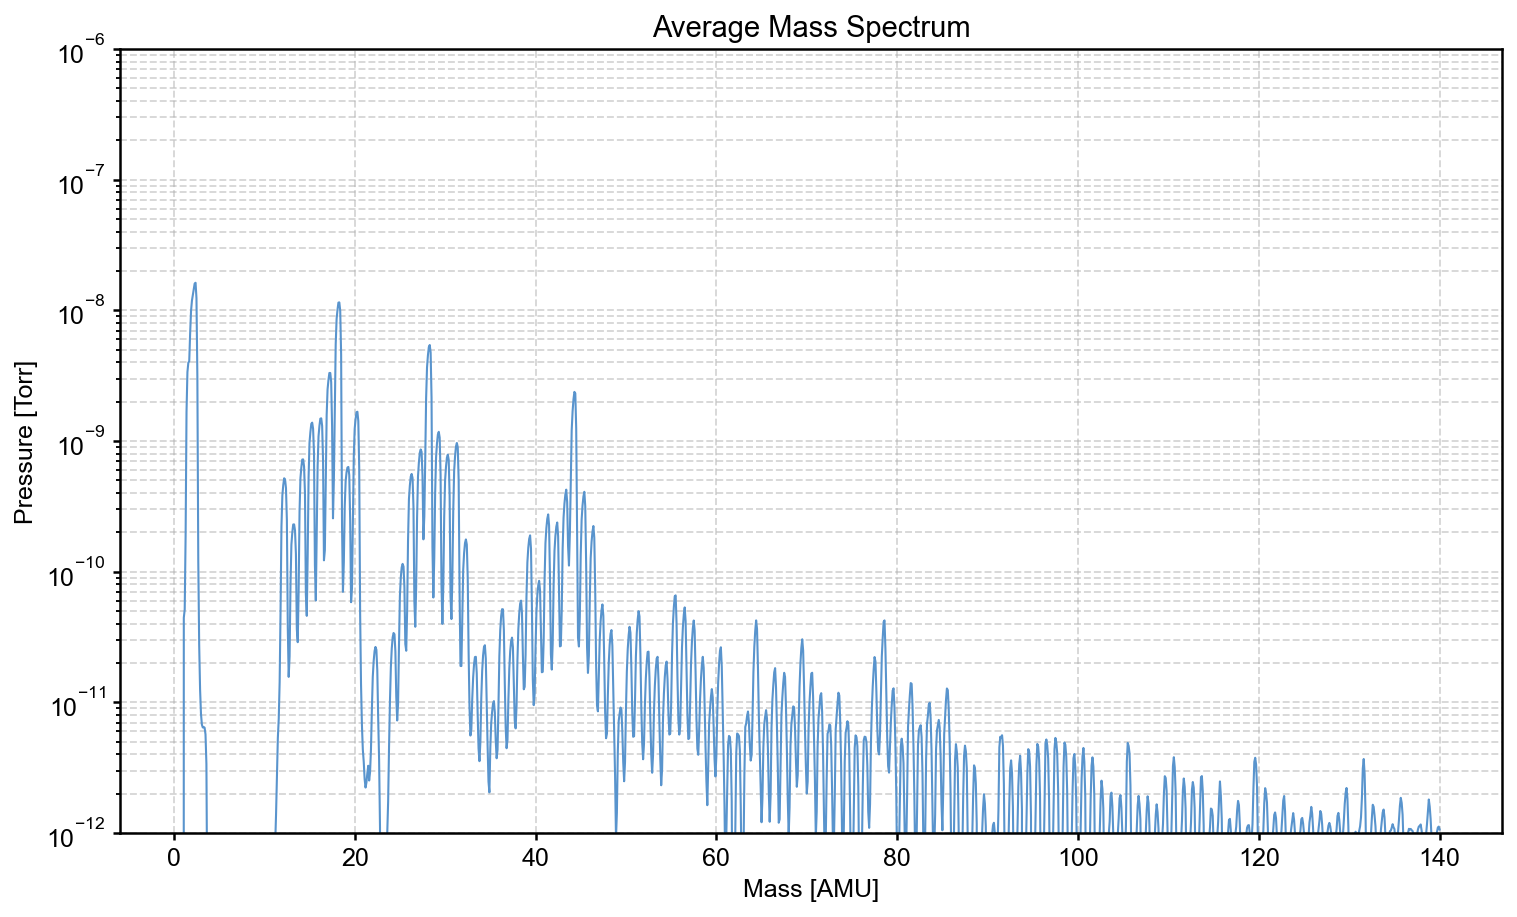

In [6]:
# Plot the average mass spectrum
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

mean_spectrum = np.nanmean(data, axis=0)
ax.semilogy(masses, mean_spectrum)

ax.set_xlabel('Mass [AMU]')
ax.set_ylabel('Pressure [Torr]')
ax.set_ylim([1e-12, 1e-6])
ax.set_title('Average Mass Spectrum')
ax.grid(which='both')
plt.show()

## Load and plot PressurevsTime data

In [7]:
# Find all PressurevsTime files
pvt_dir = Path('RGAData/PressurevsTime/')
pvt_files = sorted(pvt_dir.glob('*.rgadata'))
print(f"Found {len(pvt_files)} PressurevsTime files")
for f in pvt_files:
    print(f"  {f.name}")

Found 2 PressurevsTime files
  PressurevsTime-20260119-171218-559.rgadata
  PressurevsTime-20260119-175243-490.rgadata


In [8]:
# Load the first PressurevsTime file
pvt_result = rga.parse_rgadata_file(pvt_files[1])

print(f"Mode: {pvt_result['mode_name']}")
print(f"Gases monitored: {pvt_result['gases']}")
print(f"Gas masses: {pvt_result['gas_masses']}")
print(f"Number of samples: {pvt_result['data'].shape[0]}")
print(f"Scan start time: {rga.get_scan_time(pvt_result)}")

Mode: PressurevsTime
Gases monitored: ['H2', 'H2 O', 'N2', 'Xe129', 'Xe131', 'Xe132', 'Xe134', 'Xe136']
Gas masses: [2, 18, 28, 129, 131, 132, 134, 136]
Number of samples: 1360
Scan start time: 2026-01-19 17:52:43-05:00


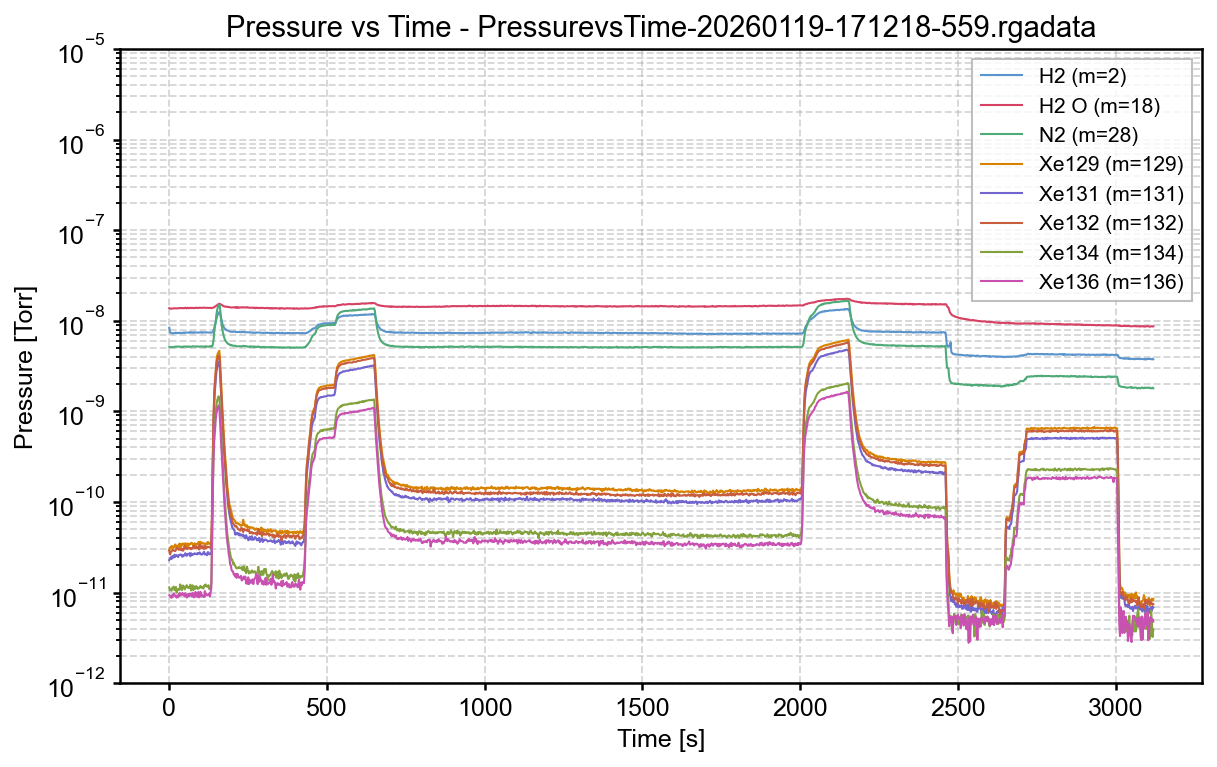

In [32]:
# Plot pressure vs time for all gases
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

times = pvt_result['timestamps'] / 1000  # Convert to seconds
data = pvt_result['data']
gases = pvt_result['gases']
gas_masses = pvt_result['gas_masses']

ccg_pressures = np.array([1.1e-6, 1.0e-6, 2.0e-7, 1.2e-6, 2.2e-7, 7.3e-8, 2.1e-7])
ccg_no_xe = np.concat((np.ones(len(ccg_pressures) - 2)*1.8e-7, np.ones(2)*6.8e-8))

gcf_vals = np.array([2.4, 1., 1., 0.4, 0.4, 0.4, 0.4, 0.4])

meas_times = np.array([2.6, 10.7, 33, 35.8, 40.9, 43.9, 49.5])*60
meas_inds = np.array([np.argmin(np.abs(times - t)) for t in meas_times])
xe_indices = [i for i, name in enumerate(gases) if 'Xe' in name]
xe_pressure = np.sum(data[meas_inds][:, xe_indices], axis=1)
tot_pressure = np.sum(data[meas_inds], axis=1)

for i, (name, mass) in enumerate(zip(gases, gas_masses)):
    ax.semilogy(times, data[:, i], label=f'{name} (m={mass})')

# ax.vlines(meas_times, 0, 1, ls='--', color='k')
# ax.plot(meas_times, xe_pressure, ls='none', marker='o', ms=3)
# ax.plot(meas_times, ccg_pressures, ls='none', marker='o', ms=3)
# ax.plot(meas_times, tot_pressure, ls='none', marker='o', ms=3)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure [Torr]')
ax.set_ylim([1e-12, 1e-5])
# ax.set_xlim([125, 225])
ax.set_title(f'Pressure vs Time - {pvt_files[0].name}')
ax.grid(which='both')
ax.legend(loc='best')
plt.show()

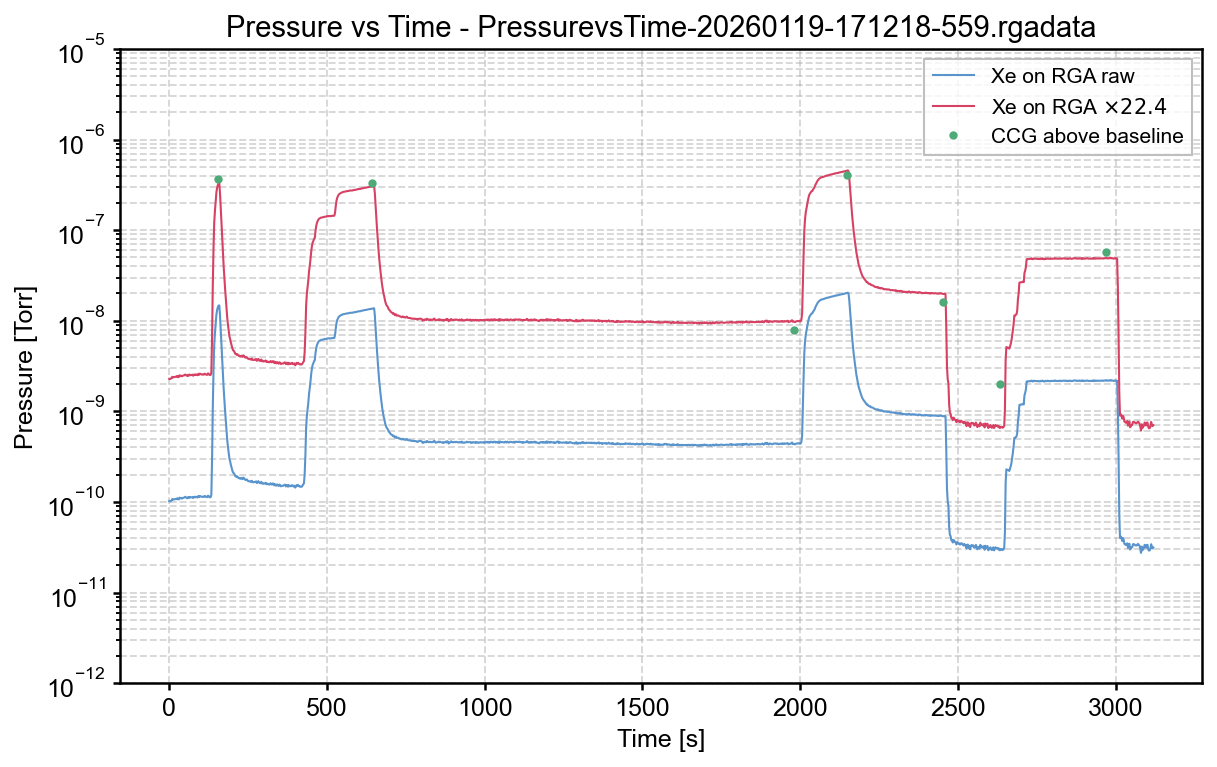

In [30]:
# Plot pressure vs time for all gases
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

times = pvt_result['timestamps'] / 1000  # Convert to seconds
data = pvt_result['data']
gases = pvt_result['gases']
gas_masses = pvt_result['gas_masses']

ccg_pressures = np.array([1.1e-6, 1.0e-6, 2.0e-7, 1.2e-6, 2.2e-7, 7.3e-8, 2.1e-7])
ccg_no_xe = np.concat((np.ones(len(ccg_pressures) - 2)*1.8e-7, np.ones(2)*6.8e-8))

gcf_vals = np.array([2.4, 1., 1., 0.4, 0.4, 0.4, 0.4, 0.4])

xe_ccg = (ccg_pressures - ccg_no_xe)*gcf_vals[-1]
xe_rga = np.sum(data[:, xe_indices], axis=1)

scaling_factors = np.linspace(5., 50., 1000)
best_factor = scaling_factors[np.argmin(np.sum((np.interp(meas_times, times, xe_rga)[:, None]*scaling_factors[None, :] - xe_ccg[:, None])**2, axis=0))]

meas_times = np.array([2.6, 10.7, 33, 35.8, 40.9, 43.9, 49.5])*60
meas_inds = np.array([np.argmin(np.abs(times - t)) for t in meas_times])
xe_indices = [i for i, name in enumerate(gases) if 'Xe' in name]
xe_pressure = np.sum(data[meas_inds][:, xe_indices], axis=1)
tot_pressure = np.sum(data[meas_inds], axis=1)

# for i, (name, mass) in enumerate(zip(gases, gas_masses)):
#     ax.semilogy(times, data[:, i], label=f'{name} (m={mass})')

ax.semilogy(times, xe_rga, label='Xe on RGA raw')
ax.semilogy(times, xe_rga*best_factor, label='Xe on RGA $\\times{:.1f}$'.format(best_factor))
ax.semilogy(meas_times, xe_ccg, ls='none', marker='o', ms=3, label='CCG above baseline')

# ax.vlines(meas_times, 0, 1, ls='--', color='k')
# ax.plot(meas_times, xe_pressure, ls='none', marker='o', ms=3)
# ax.plot(meas_times, ccg_pressures, ls='none', marker='o', ms=3)
# ax.plot(meas_times, tot_pressure, ls='none', marker='o', ms=3)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure [Torr]')
ax.set_ylim([1e-12, 1e-5])
# ax.set_xlim([125, 225])
ax.set_title(f'Pressure vs Time - {pvt_files[0].name}')
ax.grid(which='both')
ax.legend(loc='best')
plt.show()

In [76]:
ccg_pred = np.sum(data[meas_inds]/gcf_vals[None, :], axis=1)

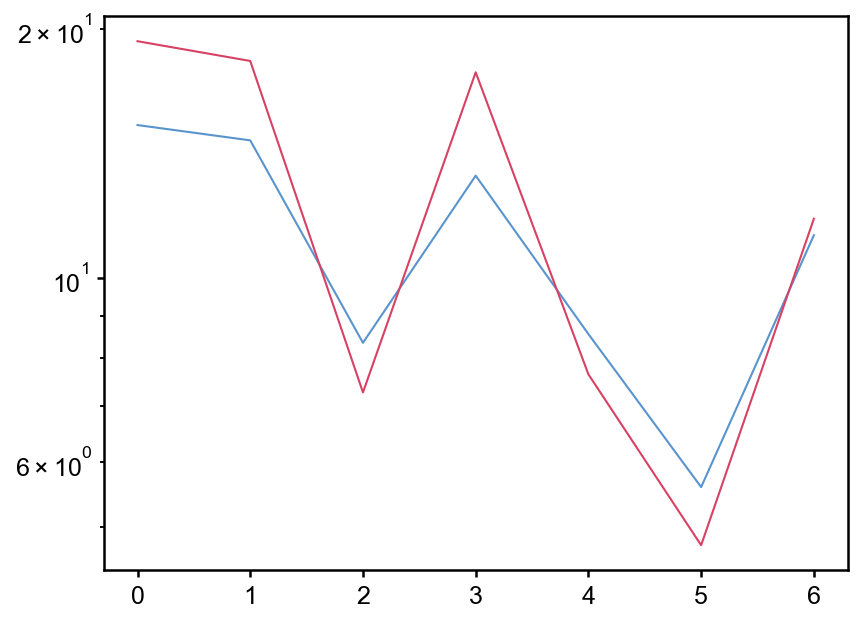

In [ ]:
# plt.plot((ccg_pressures - ccg_no_xe)*gcf_vals[-1]/xe_pressure)
# plt.plot(ccg_pressures)
plt.plot(ccg_pressures/ccg_pred, label='CCG reading / RGA reading (with GCF)')
plt.plot(ccg_pressures/tot_pressure, label='CCG reading / RGA reading (w/o GCF)')
plt.yscale('log')
plt.legend()

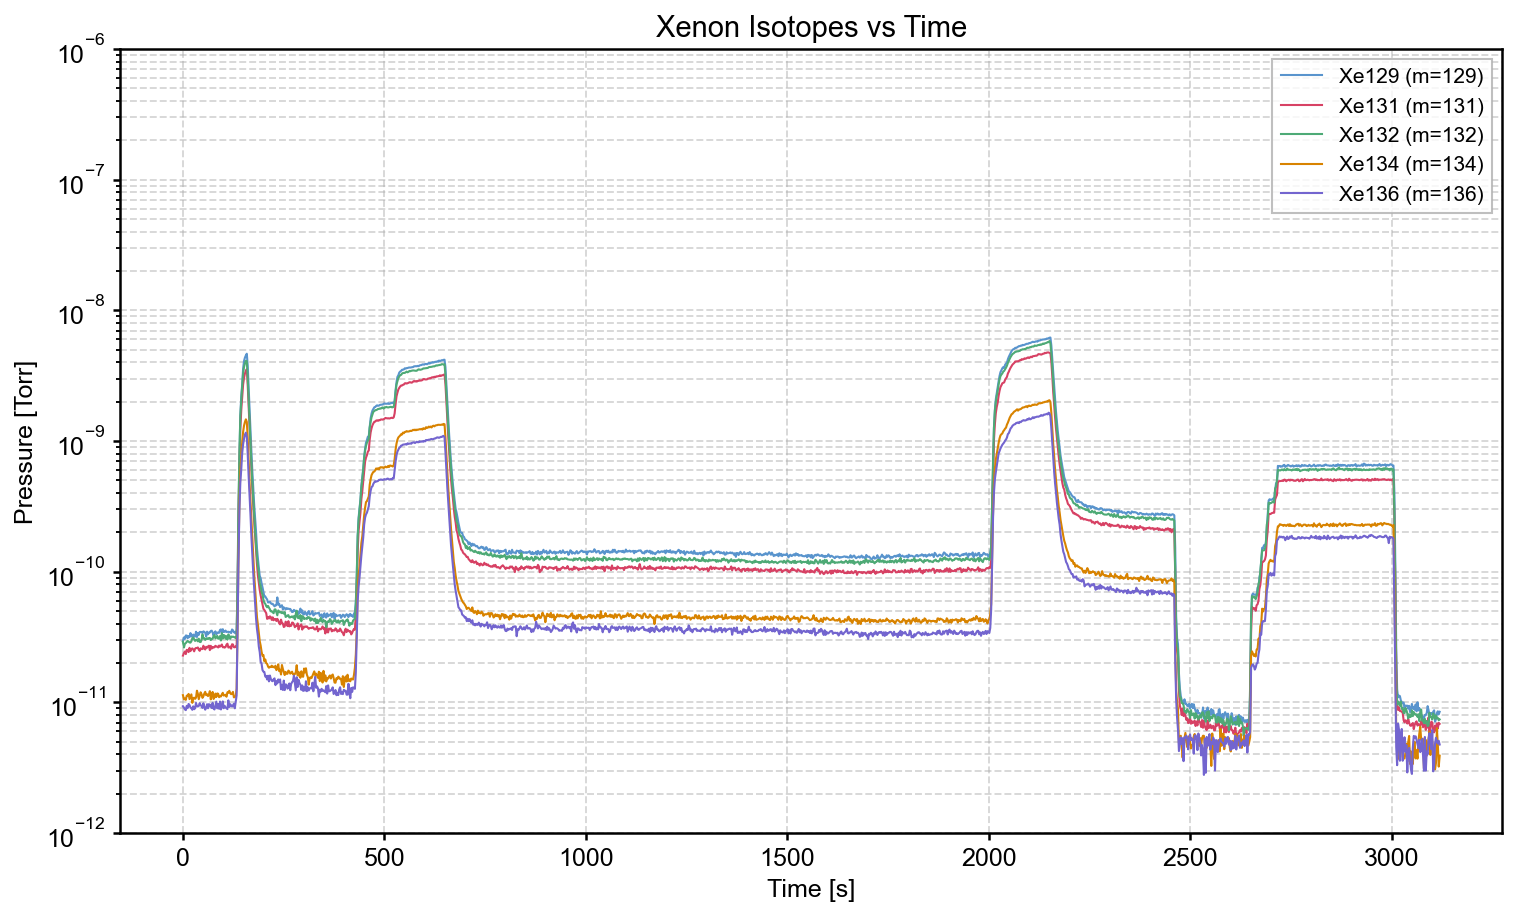

In [ ]:
# Plot just the Xenon isotopes
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

for i in xe_indices:
    ax.semilogy(times, data[:, i], label=f'{gases[i]} (m={gas_masses[i]})')

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure [Torr]')
ax.set_ylim([1e-12, 1e-6])
ax.set_title('Xenon Isotopes vs Time')
ax.grid(which='both')
ax.legend(loc='best')
plt.show()

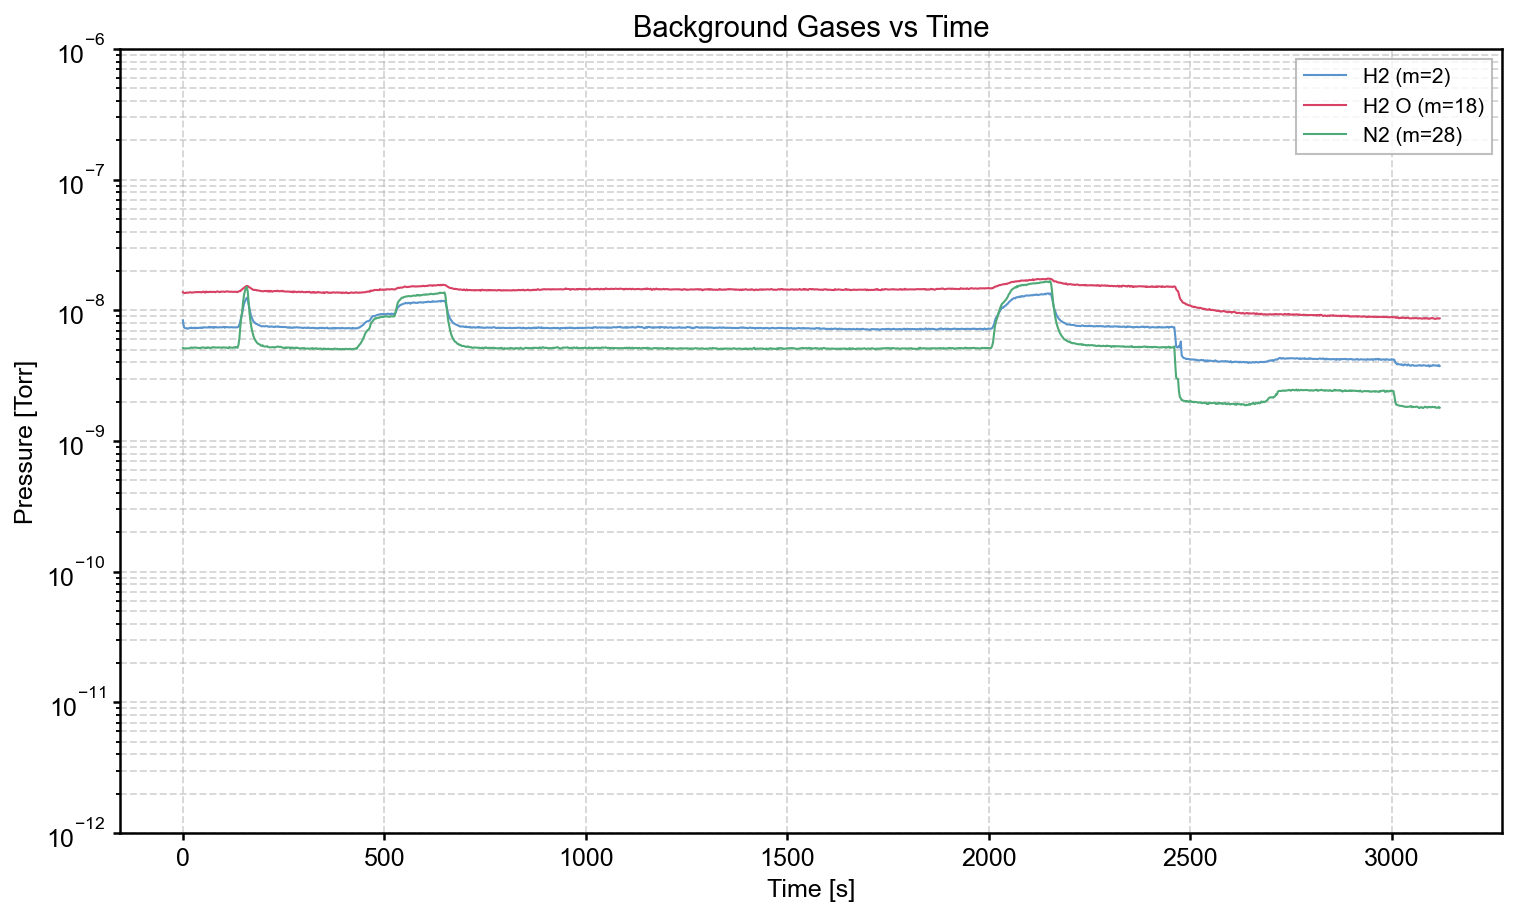

In [10]:
# Plot background gases (H2, H2O, N2)
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

bg_indices = [i for i, name in enumerate(gases) if 'Xe' not in name]

for i in bg_indices:
    ax.semilogy(times, data[:, i], label=f'{gases[i]} (m={gas_masses[i]})')

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure [Torr]')
ax.set_ylim([1e-12, 1e-6])
ax.set_title('Background Gases vs Time')
ax.grid(which='both')
ax.legend(loc='best')
plt.show()

## Debug: Explore binary file structure

Use these cells to examine the raw binary data and find the correct offsets.

In [18]:
import struct

def explore_rgadata(filepath, file_type='pvt'):
    """
    Explore the binary structure of an rgadata file.
    
    Parameters
    ----------
    filepath : str or Path
        Path to the .rgadata file
    file_type : str
        'pvt' for PressurevsTime, 'analog' for Analog scans
    """
    with open(filepath, 'rb') as f:
        content = f.read()
    
    # Find data section (after second xV4 marker)
    marker = b'xV4'
    first_marker = content.find(marker)
    second_marker = content.find(marker, first_marker + 1)
    data_start = second_marker + 3
    data_section = content[data_start:]
    
    # Find record markers (0xffffffff)
    ffff_marker = b'\xff\xff\xff\xff'
    positions = []
    pos = 0
    while True:
        idx = data_section.find(ffff_marker, pos)
        if idx == -1:
            break
        positions.append(idx)
        pos = idx + 1
    
    print(f"File: {filepath}")
    print(f"Data section starts at byte: {data_start}")
    print(f"Found {len(positions)} record markers")
    if len(positions) > 1:
        spacing = positions[1] - positions[0]
        print(f"Record spacing: {spacing} bytes")
    print()
    
    return data_section, positions

def hex_dump(data_section, start, length=64):
    """Print hex dump of data section."""
    chunk = data_section[start:start+length]
    print(f"Hex dump from offset {start} ({length} bytes):")
    for i in range(0, len(chunk), 16):
        hex_str = ' '.join(f'{b:02x}' for b in chunk[i:i+16])
        ascii_str = ''.join(chr(b) if 32 <= b < 127 else '.' for b in chunk[i:i+16])
        print(f"  {start+i:4d}: {hex_str:48s} | {ascii_str}")
    print()

def read_floats_at_offset(data_section, marker_pos, offset, n_values=10):
    """
    Read float32 values at a given offset from a marker position.
    
    Parameters
    ----------
    data_section : bytes
        The data section of the file
    marker_pos : int
        Position of the 0xffffffff marker
    offset : int
        Offset from marker to start reading floats
    n_values : int
        Number of float32 values to read
    """
    print(f"Reading {n_values} float32 values starting at marker+{offset}:")
    values = []
    for i in range(n_values):
        pos = marker_pos + offset + i * 4
        if pos + 4 <= len(data_section):
            val = struct.unpack('<f', data_section[pos:pos+4])[0]
            values.append(val)
            print(f"  [{i:2d}] offset {pos:5d} (marker+{offset + i*4:3d}): {val: .3e}")
    return values

def read_record_with_offset(data_section, marker_pos, data_offset, n_values):
    """
    Read a complete record with specified data offset.
    
    Parameters
    ----------
    data_section : bytes
        The data section of the file  
    marker_pos : int
        Position of the 0xffffffff marker
    data_offset : int
        Offset from marker where pressure data starts
    n_values : int
        Number of pressure values to read
    
    Returns
    -------
    tuple
        (timestamp_ms, pressure_values)
    """
    # Timestamp is always at marker+4
    ts = struct.unpack('<I', data_section[marker_pos+4:marker_pos+8])[0]
    
    values = []
    for i in range(n_values):
        pos = marker_pos + data_offset + i * 4
        if pos + 4 <= len(data_section):
            val = struct.unpack('<f', data_section[pos:pos+4])[0]
            if val == -1000.0:
                val = np.nan
            values.append(val)
    
    return ts, values

In [19]:
# Explore PressurevsTime file
pvt_data, pvt_positions = explore_rgadata(pvt_files[0])

# Show hex dump around first record marker
print("Structure around first record marker:")
hex_dump(pvt_data, pvt_positions[0] - 20, length=100)

File: RGAData/PressurevsTime/PressurevsTime-20260119-171218-559.rgadata
Data section starts at byte: 2310
Found 133 record markers
Record spacing: 64 bytes

Structure around first record marker:
Hex dump from offset 1 (100 bytes):
     1: 00 00 00 00 00 00 7a c4 00 00 7a c4 00 00 7a c4  | ......z...z...z.
    17: 00 00 7a c4 ff ff ff ff 09 00 00 00 00 00 00 00  | ..z.............
    33: b5 c7 21 32 a5 da 40 32 ac bb be 31 bf 4d cd 2c  | ..!2..@2...1.M.,
    49: d8 0a a5 2c cb 27 cc 2c 36 35 c0 2c 7f 8b 55 2c  | ...,.'.,65.,..U,
    65: 00 00 00 00 00 00 7a c4 00 00 7a c4 00 00 7a c4  | ......z...z...z.
    81: 00 00 7a c4 ff ff ff ff 8e 0a 00 00 00 00 00 00  | ..z.............
    97: aa dd 0b 32                                      | ...2



In [20]:
# Explore Analog file
analog_data, analog_positions = explore_rgadata(analog_files[0])

# Show hex dump around first record marker
print("Structure around first record marker:")
hex_dump(analog_data, analog_positions[0] - 20, length=120)

File: RGAData/Analog/Analog-20260119-160557-859.rgadata
Data section starts at byte: 1907
Found 96 record markers
Record spacing: 5600 bytes

Structure around first record marker:
Hex dump from offset 1 (120 bytes):
     1: 00 00 00 00 00 00 7a c4 00 00 7a c4 00 00 7a c4  | ......z...z...z.
    17: 00 00 7a c4 ff ff ff ff 6c 09 00 00 00 00 00 00  | ..z.....l.......
    33: 6f 05 00 00 7f 7d d4 2f 13 9f f4 2f ae ca f2 30  | o....}./.../...0
    49: 25 3e 6c 32 69 e2 03 33 cb 0d 3a 33 41 14 39 33  | %>l2i..3..:3A.93
    65: 16 ed 88 33 65 ce bc 33 6c 1e d9 33 42 ee f1 33  | ...3e..3l..3B..3
    81: de 38 08 34 a7 78 1a 34 b6 9e 1b 34 6f d4 fe 33  | .8.4.x.4...4o..3
    97: 8d 8f 2d 33 b9 ed 9a 30 f9 e4 2a 2f 59 18 86 2e  | ..-3...0..*/Y...
   113: 56 69 60 2e 14 08 79 2e                          | Vi`...y.



In [21]:
# Try reading float values at different offsets from the marker
# The marker is 4 bytes, timestamp is 4 bytes, so data might start at offset 8, 12, 16, etc.

print("Trying different data offsets for PressurevsTime (8 gases expected):")
print("Expected order: Hydrogen, H2O, N2, Xe129, Xe131, Xe132, Xe134, Xe136")
print("Expected values: H2 ~1e-9, H2O ~1e-9, N2 ~1e-9, Xe ~1e-11 to 1e-9")
print()

for offset in [8, 12, 16, 20]:
    print(f"--- Offset {offset} ---")
    read_floats_at_offset(pvt_data, pvt_positions[0], offset, n_values=10)
    print()

Trying different data offsets for PressurevsTime (8 gases expected):
Expected order: Hydrogen, H2O, N2, Xe129, Xe131, Xe132, Xe134, Xe136
Expected values: H2 ~1e-9, H2O ~1e-9, N2 ~1e-9, Xe ~1e-11 to 1e-9

--- Offset 8 ---
Reading 10 float32 values starting at marker+8:
  [ 0] offset    29 (marker+  8):  0.000e+00
  [ 1] offset    33 (marker+ 12):  9.417e-09
  [ 2] offset    37 (marker+ 16):  1.123e-08
  [ 3] offset    41 (marker+ 20):  5.551e-09
  [ 4] offset    45 (marker+ 24):  5.835e-12
  [ 5] offset    49 (marker+ 28):  4.691e-12
  [ 6] offset    53 (marker+ 32):  5.802e-12
  [ 7] offset    57 (marker+ 36):  5.463e-12
  [ 8] offset    61 (marker+ 40):  3.035e-12
  [ 9] offset    65 (marker+ 44):  0.000e+00

--- Offset 12 ---
Reading 10 float32 values starting at marker+12:
  [ 0] offset    33 (marker+ 12):  9.417e-09
  [ 1] offset    37 (marker+ 16):  1.123e-08
  [ 2] offset    41 (marker+ 20):  5.551e-09
  [ 3] offset    45 (marker+ 24):  5.835e-12
  [ 4] offset    49 (marker+ 28)

In [22]:
# Try reading float values at different offsets for Analog file
# 201 points expected (mass 120-140, 10 points/AMU)

print("Trying different data offsets for Analog scan:")
print("Expected: pressure values around 1e-12 to 1e-9 Torr")
print()

for offset in [8, 12, 16, 20]:
    print(f"--- Offset {offset} ---")
    read_floats_at_offset(analog_data, analog_positions[0], offset, n_values=15)
    print()

Trying different data offsets for Analog scan:
Expected: pressure values around 1e-12 to 1e-9 Torr

--- Offset 8 ---
Reading 15 float32 values starting at marker+8:
  [ 0] offset    29 (marker+  8):  0.000e+00
  [ 1] offset    33 (marker+ 12):  1.949e-42
  [ 2] offset    37 (marker+ 16):  3.865e-10
  [ 3] offset    41 (marker+ 20):  4.450e-10
  [ 4] offset    45 (marker+ 24):  1.767e-09
  [ 5] offset    49 (marker+ 28):  1.375e-08
  [ 6] offset    53 (marker+ 32):  3.071e-08
  [ 7] offset    57 (marker+ 36):  4.332e-08
  [ 8] offset    61 (marker+ 40):  4.309e-08
  [ 9] offset    65 (marker+ 44):  6.376e-08
  [10] offset    69 (marker+ 48):  8.792e-08
  [11] offset    73 (marker+ 52):  1.011e-07
  [12] offset    77 (marker+ 56):  1.127e-07
  [13] offset    81 (marker+ 60):  1.269e-07
  [14] offset    85 (marker+ 64):  1.439e-07

--- Offset 12 ---
Reading 15 float32 values starting at marker+12:
  [ 0] offset    33 (marker+ 12):  1.949e-42
  [ 1] offset    37 (marker+ 16):  3.865e-10
  

In [23]:
# Once you find the correct offset, test it here and plot
# Adjust DATA_OFFSET to the correct value

DATA_OFFSET = 12  # <-- Change this to the correct offset

# Test on PressurevsTime
n_gases = 8
gas_names = ['Hydrogen', 'H2O', 'N2', 'Xe129', 'Xe131', 'Xe132', 'Xe134', 'Xe136']

print(f"Testing PressurevsTime with data offset = {DATA_OFFSET}")
print()

# Read first few records
for rec_idx in range(3):
    ts, values = read_record_with_offset(pvt_data, pvt_positions[rec_idx], DATA_OFFSET, n_gases)
    print(f"Record {rec_idx}: timestamp = {ts} ms")
    for i, (name, val) in enumerate(zip(gas_names, values)):
        print(f"  {name:12s}: {val:.2e} Torr")
    print()

Testing PressurevsTime with data offset = 12

Record 0: timestamp = 9 ms
  Hydrogen    : 9.42e-09 Torr
  H2O         : 1.12e-08 Torr
  N2          : 5.55e-09 Torr
  Xe129       : 5.84e-12 Torr
  Xe131       : 4.69e-12 Torr
  Xe132       : 5.80e-12 Torr
  Xe134       : 5.46e-12 Torr
  Xe136       : 3.03e-12 Torr

Record 1: timestamp = 2702 ms
  Hydrogen    : 8.14e-09 Torr
  H2O         : 1.11e-08 Torr
  N2          : 5.45e-09 Torr
  Xe129       : 4.86e-12 Torr
  Xe131       : 5.30e-12 Torr
  Xe132       : 4.84e-12 Torr
  Xe134       : 4.59e-12 Torr
  Xe136       : 4.48e-12 Torr

Record 2: timestamp = 4994 ms
  Hydrogen    : 8.00e-09 Torr
  H2O         : 1.10e-08 Torr
  N2          : 5.46e-09 Torr
  Xe129       : 6.05e-12 Torr
  Xe131       : 5.56e-12 Torr
  Xe132       : 5.82e-12 Torr
  Xe134       : 4.41e-12 Torr
  Xe136       : 3.79e-12 Torr



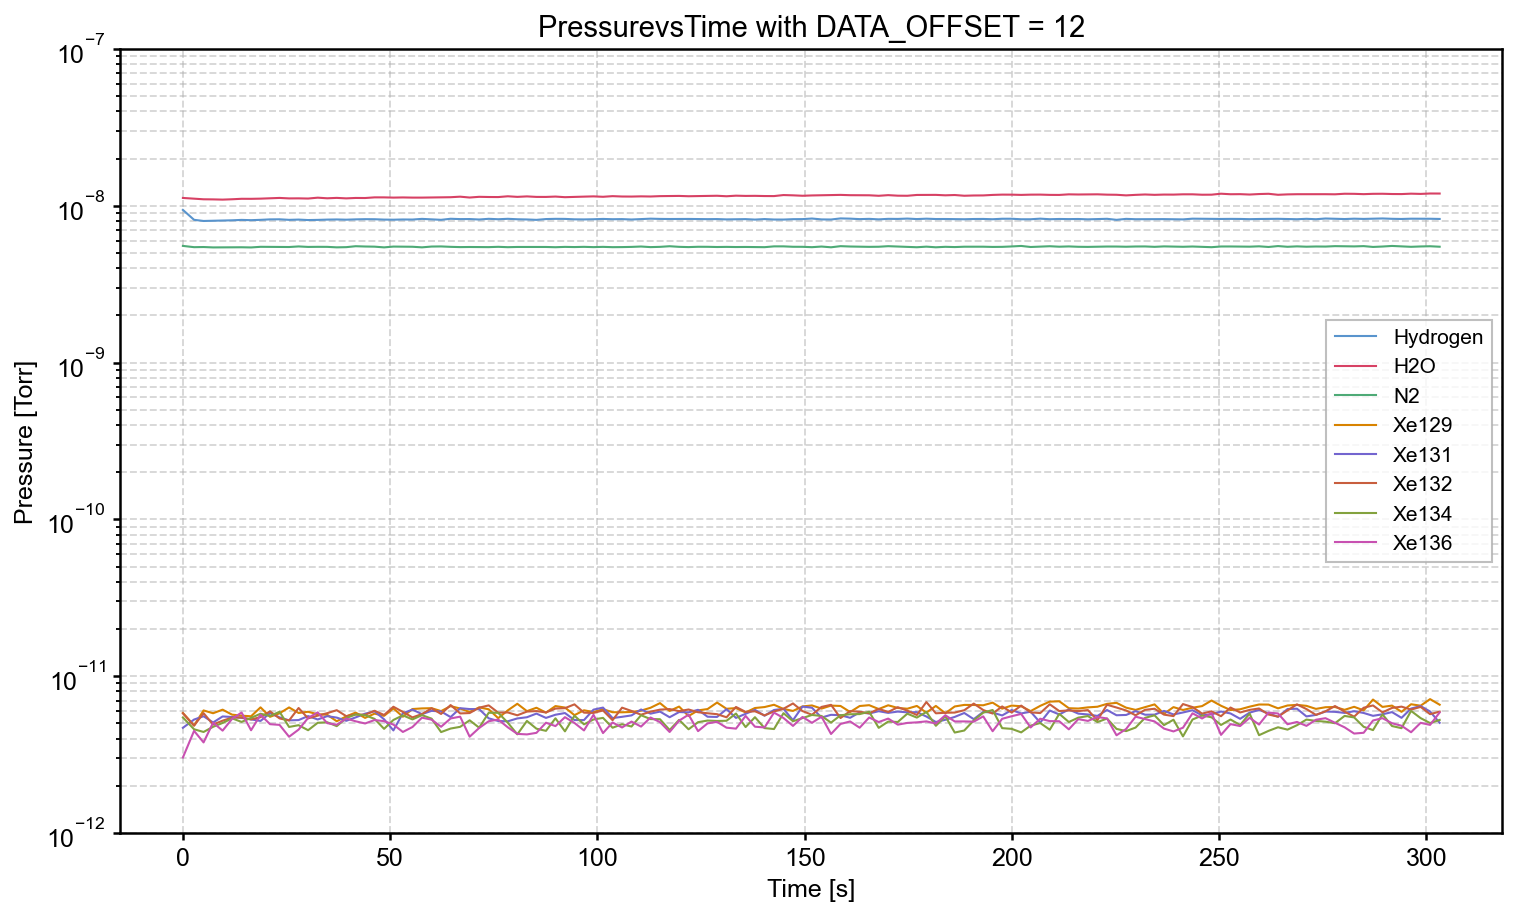


Pressure ranges:
  Hydrogen    : 8.00e-09 - 9.42e-09 Torr
  H2O         : 1.10e-08 - 1.20e-08 Torr
  N2          : 5.43e-09 - 5.55e-09 Torr
  Xe129       : 4.86e-12 - 7.15e-12 Torr
  Xe131       : 4.52e-12 - 6.46e-12 Torr
  Xe132       : 4.84e-12 - 6.85e-12 Torr
  Xe134       : 4.14e-12 - 6.10e-12 Torr
  Xe136       : 3.03e-12 - 5.88e-12 Torr


In [24]:
# Plot PressurevsTime data with custom offset to verify it looks correct

def parse_all_records(data_section, positions, data_offset, n_values):
    """Parse all records with a given data offset."""
    timestamps = []
    all_pressures = []
    for marker_pos in positions:
        ts, values = read_record_with_offset(data_section, marker_pos, data_offset, n_values)
        if len(values) == n_values:
            timestamps.append(ts)
            all_pressures.append(values)
    return np.array(timestamps), np.array(all_pressures)

# Parse with custom offset
ts_custom, data_custom = parse_all_records(pvt_data, pvt_positions, DATA_OFFSET, n_gases)

# Plot
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

times = ts_custom / 1000  # Convert to seconds

for i, name in enumerate(gas_names):
    ax.semilogy(times, data_custom[:, i], label=name)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure [Torr]')
ax.set_title(f'PressurevsTime with DATA_OFFSET = {DATA_OFFSET}')
ax.grid(which='both')
ax.legend(loc='best')
ax.set_ylim([1e-12, 1e-7])
plt.show()

print(f"\nPressure ranges:")
for i, name in enumerate(gas_names):
    valid = data_custom[:, i][~np.isnan(data_custom[:, i])]
    if len(valid) > 0:
        print(f"  {name:12s}: {valid.min():.2e} - {valid.max():.2e} Torr")